# **DermaMNIST**

The DermaMNIST is based on the HAM10000, a **large collection of multi-source dermatoscopic images of common pigmented skin lesions**.

The dataset consists of 10015 dermatoscopic images categorized as **7 different diseases**, formulized as a *multi-class classification task*.

We split the images into training, validation and test set with a ratio of 7:1:2.

The source images of $3 \times 600 \times 450$ are resized into $3\times 28 \times 28$. The DermaMNIST contains colored images (RGB images) with 3 color channels.

In [1]:
url = "https://zenodo.org/record/6496656/files/dermamnist.npz?download=1"

descriptions = {
    0: "actinic keratoses and intraepithelial carcinoma",
    1: "basal cell carcinoma",
    2: "benign keratosis-like lesions",
    3: "dermatofibroma",
    4: "melanoma",
    5: "melanocytic nevi",
    6: "vascular lesions"
}


    Jiancheng Yang, Rui Shi, Donglai Wei, Zequan Liu, Lin Zhao, Bilian Ke, Hanspeter Pfister, Bingbing Ni. Yang, Jiancheng, et al. "MedMNIST v2-A large-scale lightweight benchmark for 2D and 3D biomedical image classification." Scientific Data, 2023.

    Jiancheng Yang, Rui Shi, Bingbing Ni. "MedMNIST Classification Decathlon: A Lightweight AutoML Benchmark for Medical Image Analysis". IEEE 18th International Symposium on Biomedical Imaging (ISBI), 2021.


Let's load the data from the URL above.

In [2]:
import numpy as np
from tensorflow import keras

# Load data from URL 'origin' to local 'data_path'
data_path = keras.utils.get_file(
    fname="dermamnist.npz",
    origin=url
)
# Load data
data = np.load(data_path)

# Create numpy arrays for training, validation and test images and labels
X_train = data["train_images"]
X_val = data["val_images"]
X_test = data["test_images"]
y_train = data["train_labels"]
y_val = data["val_labels"]
y_test = data["test_labels"]

2025-07-23 15:07:21.473067: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-23 15:07:21.563848: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-23 15:07:21.654675: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753276041.742340   17280 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753276041.773253   17280 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753276041.845635   17280 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

19725078/19725078 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


## Import

In [3]:
import copy
import itertools
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from keras.utils import to_categorical
from tensorflow.keras import Sequential, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy, CategoricalFocalCrossentropy 
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import CategoricalAccuracy

## The dataset

Let's check the number of images in the dataset.

In [4]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(7007, 28, 28, 3)
(1003, 28, 28, 3)
(2005, 28, 28, 3)
(7007, 1)
(1003, 1)
(2005, 1)


### Sample image

Here is a typical image.

In [5]:
X_train[0].shape

(28, 28, 3)

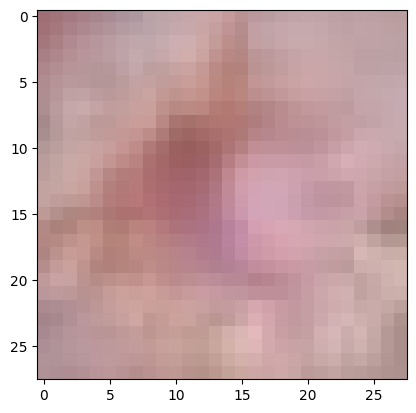

In [6]:
plt.imshow(X_train[0]);

In [7]:
X_train.shape

(7007, 28, 28, 3)

### Classes

There are 7 classes, the description of which is provided in the original [paper](https://www.nature.com/articles/sdata2018161.pdf):

Tschandl P., Rosendahl C., Kittler H. The HAM10000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions //Scientific data. – 2018. – Т. 5. – №. 1. – С. 1-9.

In [9]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6], dtype=uint8)

So, each of the diseases is shown as an integer. We will apply one-hot encoding for them.

### Balance of classes

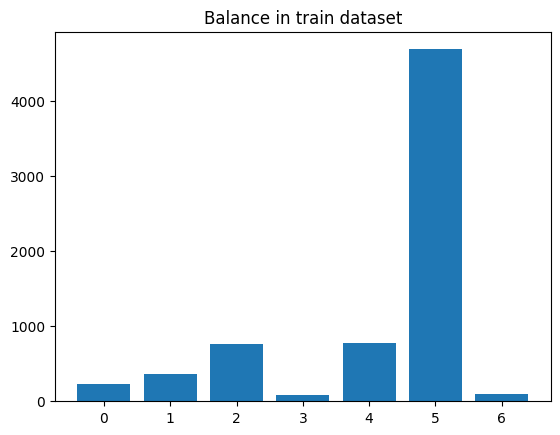

In [10]:
train_class_numbers = np.unique(y_train, return_counts=True)
plt.bar(train_class_numbers[0], train_class_numbers[1])
plt.title("Balance in train dataset")
plt.show()

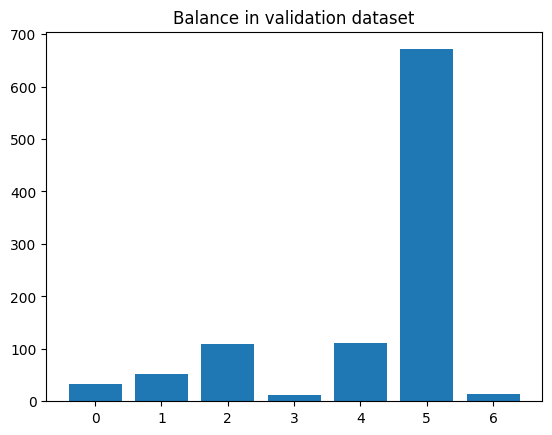

In [11]:
val_class_numbers = np.unique(y_val, return_counts=True)
plt.bar(val_class_numbers[0], val_class_numbers[1])
plt.title("Balance in validation dataset")
plt.show()

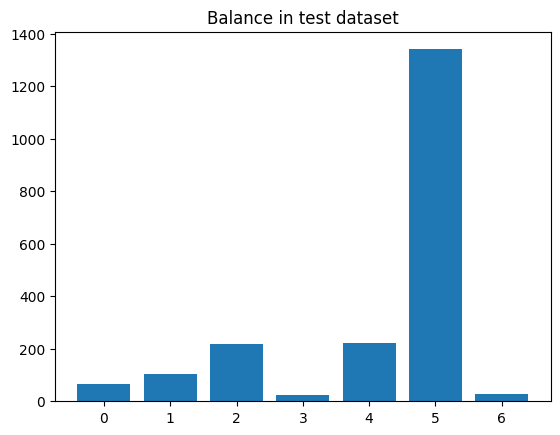

In [12]:
test_class_numbers = np.unique(y_test, return_counts=True)
plt.bar(test_class_numbers[0], test_class_numbers[1])
plt.title("Balance in test dataset")
plt.show()

In [13]:
total_classes = np.unique(np.concatenate([y_train, y_val, y_test]), return_counts=True)
for i in range(len(total_classes[0])):
    print('Percentage of class {} is {}%'.format(total_classes[0][i], round(total_classes[1][i]/sum(total_classes[1])*100, 1)))

Percentage of class 0 is 3.3%
Percentage of class 1 is 5.1%
Percentage of class 2 is 11.0%
Percentage of class 3 is 1.1%
Percentage of class 4 is 11.1%
Percentage of class 5 is 66.9%
Percentage of class 6 is 1.4%


There is a huge class imbalance that should be taken into account.  
Class 5 represent *melanocytic nevi* which are benign neoplasms.  
Hovewer, the three samples look similarly.  

### Plotting samples

#### Actinic keratoses and intraepithelial carcinoma

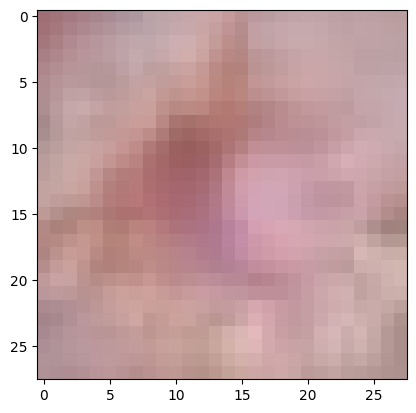

In [14]:
first_image = X_train[np.where(y_train == 0)[0][0]]
plt.imshow(first_image)
plt.savefig("Actinic_keratoses_and_intraepithelial_carcinoma.png")

#### Basal cell carcinoma

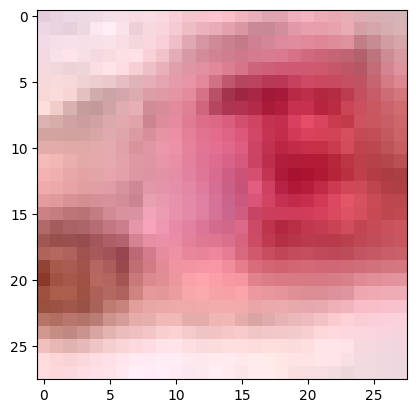

In [15]:
first_image = X_train[np.where(y_train == 1)[0][0]]
plt.imshow(first_image)
plt.savefig("Basal_cell_carcinoma.png")

#### Benign keratosis-like lesions

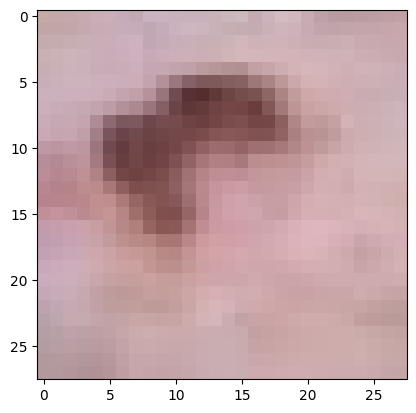

In [16]:
first_image = X_train[np.where(y_train == 2)[0][0]]
plt.imshow(first_image)
plt.savefig("Benign_keratosis-like_lesions.png")

#### Dermatofibroma

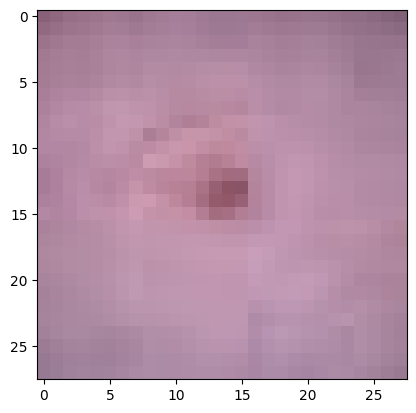

In [17]:
first_image = X_train[np.where(y_train == 3)[0][0]]
plt.imshow(first_image)
plt.savefig("Dermatofibroma.png")

#### Melanoma

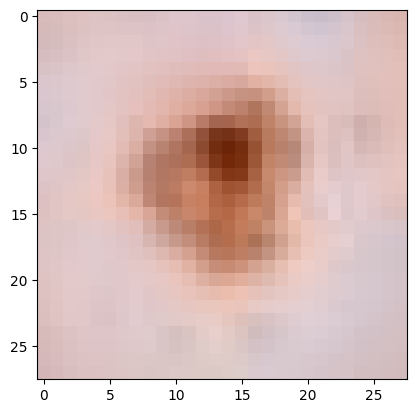

In [18]:
first_image = X_train[np.where(y_train == 4)[0][0]]
plt.imshow(first_image)
plt.savefig("Melanoma.png")

#### Melanocytic nevi (benign)

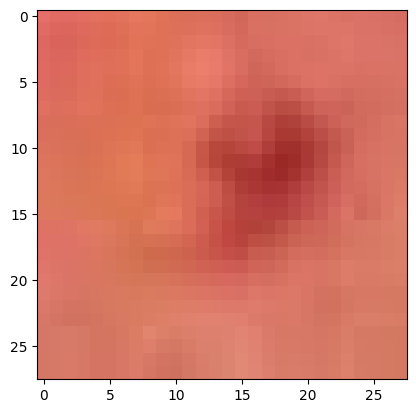

In [19]:
first_image = X_train[np.where(y_train == 5)[0][0]]
plt.imshow(first_image)
plt.savefig("Melanocytic_nevi_(benign).png")

#### Vascular lesions

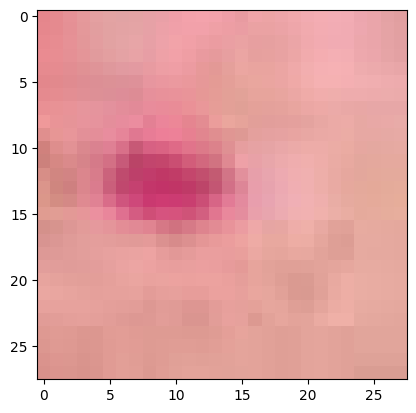

In [20]:
first_image = X_train[np.where(y_train == 6)[0][0]]
plt.imshow(first_image)
plt.savefig("Vascular_lesions.png")

## Data preprocessing

Image preprocessing consists from scaling, label preprocessing - one-hot encoding.

In [21]:
X_train = X_train/255
X_val= X_val/255
X_test = X_test/255

In [22]:
y_train_ohe = to_categorical(y_train, num_classes=7)
y_val_ohe = to_categorical(y_val, num_classes=7)
y_test_ohe = to_categorical(y_test, num_classes=7)

In [23]:
y_train_ohe

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

## Model training

To test different architectures and training samples, let's set a default training process as a baseline.

### Default model

In [24]:
MODEL = Sequential(
    [
        layers.Input((28, 28, 3)),
        layers.Flatten(),
        layers.Dense(50, activation='linear'),
        layers.Dense(50, activation='tanh'),
        layers.Dense(50, activation='relu'),
        layers.Dense(50, activation='tanh'),
        layers.Dense(7, activation='softmax')
    ]
)
MODEL.summary()

2025-07-23 15:08:43.668627: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 2352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │       117,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │           357 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,657 (490.85 KB)

 Trainable params: 125,657 (490.85 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
LEARNING_RATE=0.0001
BATCH_SIZE=8
EPOCHS=20

In [26]:
CLASS_WEIGHTS = None
CALLBACKS = None
LOSS = CategoricalCrossentropy()
METRIC = 'accuracy'

In [27]:
def train_model(X_train=X_train, y_train_ohe=y_train_ohe, 
                X_val=X_val, y_val_ohe=y_val_ohe, 
                X_test=X_test, y_test=y_test, 
                model=MODEL, 
                learning_rate=LEARNING_RATE, 
                batch_size=BATCH_SIZE, 
                epochs=EPOCHS, 
                class_weights=CLASS_WEIGHTS, 
                callbacks=CALLBACKS, 
                metric=METRIC, 
                loss=LOSS):
    
    # compile the model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate), 
        loss=loss, 
        metrics=[metric]
    )
    
    # train the model
    history = model.fit(
        X_train, y_train_ohe, 
        batch_size=batch_size, 
        epochs=epochs, 
        validation_data=(X_val, y_val_ohe), 
        class_weight=class_weights, 
        callbacks=callbacks, 
        verbose=0, 
        shuffle=True
    )
    
    # save the model
    model_name = 'DermaMNIST_learning_rate={}_batch_size={}_epochs={}_dense_layers_'.format(learning_rate, batch_size, epochs)
    for layer in model.layers:
        if layer.__class__.__name__ == 'Dense':
            model_name += str(layer.output.shape[1]) + '_' + layer.activation.__name__
    model.save(model_name + '.keras')
    
    # plot training process
    model_history = pd.DataFrame(history.history)
    model_history["epoch"] = history.epoch
    
    fig, ax = plt.subplots(nrows=2, figsize=(10, 10))
    
    ax[0].plot(model_history["epoch"], model_history["loss"], marker='o', label="Training Cross Entropy Loss")
    ax[0].plot(model_history["epoch"], model_history["val_loss"], marker='x', label="Validation Cross Entropy Loss")
    ax[0].legend()
    
    ax[1].plot(model_history["epoch"], model_history[metric], marker='o', label="Training Accuracy")
    ax[1].plot(model_history["epoch"], model_history["val_accuracy"], marker='x', label="Validation Accuracy")
    ax[1].legend()
    
    plt.savefig("Learning_curve_{}.png".format(model_name))
    plt.show()

    # plot confusion matrix on the test data
    y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)

    cm = confusion_matrix(y_test, y_pred)
    classes = [str(i) for i in range(7)]

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(cm, cmap=plt.cm.Blues)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            ax.text(j, i, cm[i, j],
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    
    plt.savefig("Confusion_matrix_{}.png".format(model_name))
    plt.show()

    f1 = f1_score(y_test, y_pred, average=None)
    print('F1-score = {}'.format(f1.mean()))
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy = {}'.format(accuracy))

2025-07-23 15:09:03.698047: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65921856 exceeds 10% of free system memory.


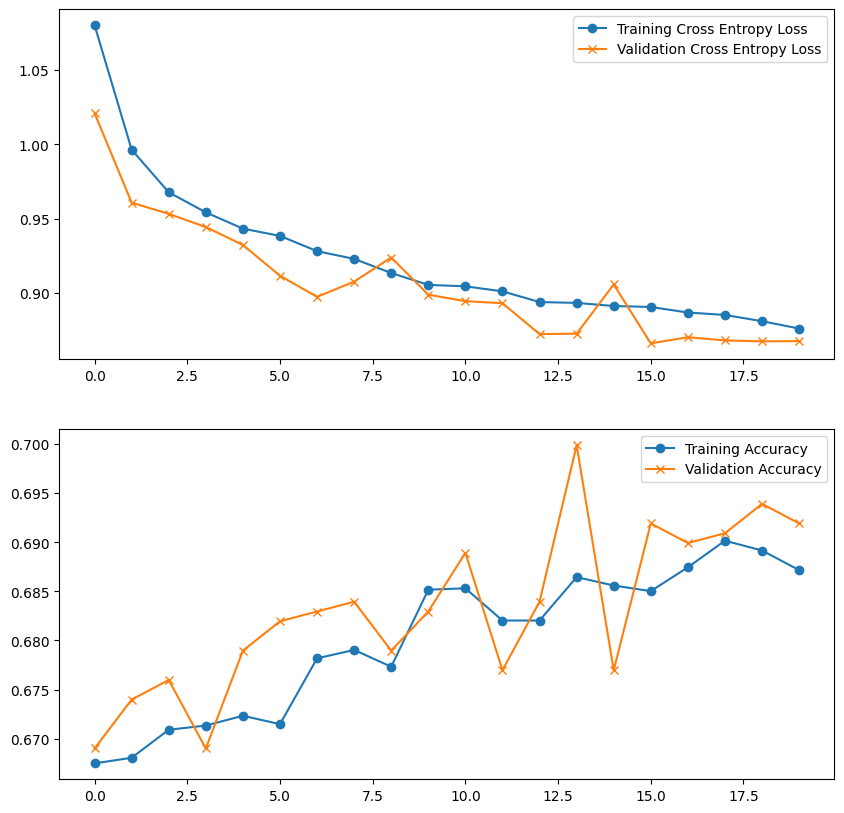

2025-07-23 15:10:20.175307: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 18863040 exceeds 10% of free system memory.


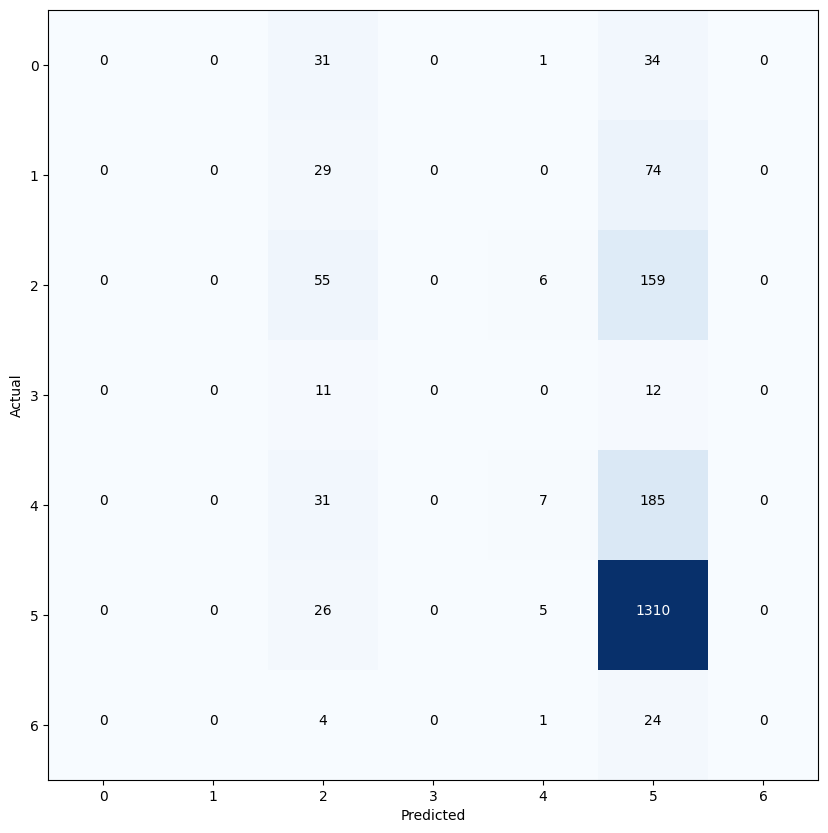

F1-score = 0.16607773699558062
Accuracy = 0.68428927680798


In [28]:
train_model()

Because of the imbalance, F1-score is more important than accuracy.

### Class balancing

Let's try two approaches:
- downsampling & upsampling to achieve similar ratio across all the classes
- class weights of 2:1 for each of the pathogenic classes compared to benign one

#### Downsampling

Let's downsample benign class to 2000 images. 

In [28]:
SIZE = 2000 
total_values = np.unique(y_train, return_counts=True)[1][5]
indices_to_drop = np.random.choice(np.where(y_train == 5)[0], size=total_values-SIZE, replace=False)
X_train_down = np.delete(X_train, indices_to_drop, axis=0)
y_train_down = np.delete(y_train, indices_to_drop, axis=0)

In [29]:
print(X_train_down.shape)
print(y_train_down.shape)

(4314, 28, 28, 3)
(4314, 1)


#### Upsampling

In [30]:
np.unique(y_train_down, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6], dtype=uint8),
 array([ 228,  359,  769,   80,  779, 2000,   99]))

One the one hand, the imbalance of the pathogenic classes should be compensated with augmentations and class weights.  
On the other hand, if the model focuses on pathogenic classes too much, there will be many false positive answers.  
So, the adjustment of the imbalance need to be moderate.

Let's try two strategies:
1. Create augmentations for classes 0, 1, 2, 4, 6 and multiply them until they reach half the size of benign class.
2. Create augmentations for all classes except 5 anf multiply them until they reach the size of the benign class.

In [31]:
datagen_horizontal = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

datagen_vertical = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    vertical_flip=True
)

In [32]:
X_train_balanced = copy.deepcopy(X_train_down)
y_train_balanced = copy.deepcopy(y_train_down)

for pathogenic_class in [0, 1, 3, 6]:
    
    indices = np.where(y_train == pathogenic_class)[0]
    
    horizontal = next(datagen_horizontal.flow(X_train[indices], batch_size=len(indices)))
    vertical = next(datagen_vertical.flow(X_train[indices], batch_size=len(indices)))

    TIMES = round(SIZE/(len(indices)*6))

    X_train_balanced = np.concatenate(
        (
            X_train_balanced, 
            np.repeat(X_train[indices], TIMES-1, axis=0), 
            np.repeat(horizontal, TIMES, axis=0), 
            np.repeat(vertical, TIMES, axis=0)
        ), axis=0
    )
    
    y_train_balanced = np.concatenate(
        (
            y_train_balanced, 
            np.repeat(pathogenic_class, len(indices)*(TIMES-1)).reshape(-1, 1), 
            np.repeat(pathogenic_class, len(indices)*TIMES).reshape(-1, 1), 
            np.repeat(pathogenic_class, len(indices)*TIMES).reshape(-1, 1)
        ), axis=0
    )

In [33]:
print(X_train_balanced.shape)
print(y_train_balanced.shape)

(7160, 28, 28, 3)
(7160, 1)


In [34]:
np.unique(y_train_balanced, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([ 684, 1077,  769,  960,  779, 2000,  891]))

In [35]:
X_train_equal = copy.deepcopy(X_train_down)
y_train_equal = copy.deepcopy(y_train_down)

for pathogenic_class in [0, 1, 2, 3, 4, 6]:
    
    indices = np.where(y_train == pathogenic_class)[0]
    
    horizontal = next(datagen_horizontal.flow(X_train[indices], batch_size=len(indices)))
    vertical = next(datagen_vertical.flow(X_train[indices], batch_size=len(indices)))

    TIMES = round(SIZE/(len(indices)*3))

    X_train_equal = np.concatenate(
        (
            X_train_equal, 
            np.repeat(X_train[indices], TIMES-1, axis=0), 
            np.repeat(horizontal, TIMES, axis=0), 
            np.repeat(vertical, TIMES, axis=0)
        ), axis=0
    )
    
    y_train_equal = np.concatenate(
        (
            y_train_equal, 
            np.repeat(pathogenic_class, len(indices)*(TIMES-1)).reshape(-1, 1), 
            np.repeat(pathogenic_class, len(indices)*TIMES).reshape(-1, 1), 
            np.repeat(pathogenic_class, len(indices)*TIMES).reshape(-1, 1)
        ), axis=0
    )

In [36]:
print(X_train_equal.shape)
print(y_train_equal.shape)

(14849, 28, 28, 3)
(14849, 1)


In [37]:
np.unique(y_train_equal, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([2052, 2154, 2307, 1920, 2337, 2000, 2079]))

In [38]:
y_train_balanced_ohe = to_categorical(y_train_balanced, num_classes=7)
y_train_equal_ohe = to_categorical(y_train_equal, num_classes=7)

Now it is possible to test which of them gives a better result.

In [ ]:
train_model(X_train_balanced, y_train_balanced_ohe)

F1-score = 0.45568676325907403  
Accuracy = 0.6369077306733167

In [ ]:
train_model(X_train_equal, y_train_equal_ohe)

F1-score = 0.3962910872718206  
Accuracy = 0.5895261845386534

Seems like the first approach is better.  
But somehow both of them are worse than training on the sample without augmentations.  
So, this idea is rejected.

#### Class weights

In [39]:
WEIGHTS = {0: 2., 1: 2., 2: 2., 3: 2., 4: 2., 5: 1., 6: 2.}

In [ ]:
y_integers = np.argmax(y_train_equal_ohe, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
WEIGHTS = dict(enumerate(class_weights))

In [ ]:
train_model(X_train, y_train_ohe, class_weights=WEIGHTS)

F1-score = 0.4773219619811864  
Accuracy = 0.7052369077306733

Seems like the weighing deteriorates prediction of the benign lesions, but does not improve the prediction of pathogenic classes.  
Better not to use it.

### Architecture

Let's try different models.

#### FCNN

In [40]:
model_1 = Sequential(
    [
        layers.Input((28, 28, 3)),
        layers.Flatten(),
        layers.Dense(100, activation='relu'),
        layers.Dense(70, activation='sigmoid'),
        layers.Dense(50, activation='tanh'),
        layers.Dense(30, activation='linear'),
        layers.Dense(10, activation='linear'),
        layers.Dense(7, activation='softmax')
    ]
)

In [ ]:
train_model(model=model_1, X_train=X_train, y_train_ohe=y_train_ohe)

F1-score = 0.4248666766474862  
Accuracy = 0.7386533665835412

In [41]:
model_2 = Sequential(
    [
        layers.Input((28, 28, 3)),
        layers.Flatten(),
        layers.Dense(20, activation='relu'),
        layers.Dense(50, activation='relu'),
        layers.Dense(100, activation='relu'),
        layers.Dense(50, activation='relu'),
        layers.Dense(20, activation='relu'),
        layers.Dense(7, activation='softmax')
    ]
)

In [ ]:
train_model(model=model_2, X_train=X_train, y_train_ohe=y_train_ohe)

F1-score = 0.40309495084145414  
Accuracy = 0.7172069825436409

The strategy of decreasing the number of nodes works better.

#### Dropout

Let's try to reduce overfitting with dropout.

In [42]:
# a model to compare with
model_3 = Sequential(
    [
        layers.Input((28, 28, 3)),
        layers.Flatten(),
        layers.Dense(100, activation='relu'),
        layers.Dense(70, activation='relu'),
        layers.Dense(50, activation='relu'),
        layers.Dense(30, activation='relu'),
        layers.Dense(7, activation='softmax')
    ]
)

In [ ]:
train_model(model=model_3, X_train=X_train_balanced, y_train_ohe=y_train_balanced_ohe, epochs=100)

F1-score = 0.4321699922797575  
Accuracy = 0.6902743142144638

In [43]:
model_4 = Sequential(
    [
        layers.Input((28, 28, 3)),
        layers.Flatten(),
        layers.Dense(100, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(70, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(50, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(30, activation='relu'),
        layers.Dense(7, activation='softmax')
    ]
)

In [ ]:
train_model(model=model_4, X_train=X_train_balanced, y_train_ohe=y_train_balanced_ohe, epochs=100)

F1-score = 0.37738672920365124  
Accuracy = 0.6169576059850375

Seems like dropout does not help.

#### Convolution

Let's try to add a two-dimentional convolution layer.

In [44]:
model_5 = Sequential(
    [
        layers.Input((28, 28, 3)),
        layers.Conv2D(filters=3, kernel_size=(3, 3)), 
        layers.Flatten(),
        layers.Dense(20, activation='sigmoid'),
        layers.Dense(50, activation='relu'),
        layers.Dense(50, activation='relu'),
        layers.Dense(50, activation='relu'),
        layers.Dense(20, activation='tanh'),
        layers.Dense(7, activation='softmax')
    ]
)

In [ ]:
train_model(model=model_5, X_train=X_train_balanced, y_train_ohe=y_train_balanced_ohe)

F1-score = 0.4193738545619386  
Accuracy = 0.6598503740648379

We can also test convolution with pooling (e.g. small ResNet).

In [45]:
model_6 = Sequential(
    [
        layers.Input((28, 28, 3)),
        layers.Conv2D(filters=3, kernel_size=(2, 2)), 
        layers.BatchNormalization(), 
        layers.Activation('relu'), 
        layers.MaxPooling2D(pool_size=(2, 2)), 
        layers.GlobalAveragePooling2D(), 
        layers.Flatten(),
        layers.Dense(100, activation='relu'),
        layers.Dense(70, activation='relu'),
        layers.Dense(50, activation='relu'),
        layers.Dense(30, activation='relu'),
        layers.Dense(7, activation='softmax')
    ]
)
model_6.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 27, 27, 3)      │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 27, 27, 3)      │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 27, 27, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 3)              │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 100)            │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 70)             │         7,070 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 50)             │         3,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 30)             │         1,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 7)              │           217 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,818 (50.07 KB)

 Trainable params: 12,812 (50.05 KB)

 Non-trainable params: 6 (24.00 B)

In [ ]:
train_model(model=model_6, X_train=X_train_balanced, y_train_ohe=y_train_balanced_ohe, epochs=100)

F1-score = 0.2797570858268072  
Accuracy = 0.5745635910224439

Well, it did not work.

#### ChatGPT model

Just a model ChatGPT recommended.

In [46]:
model_7 = Sequential(
    [
        layers.Input((28, 28, 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
    
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
    
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.Flatten(),
    
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(7, activation='softmax')
    ]
)

In [ ]:
train_model(model=model_7, X_train=X_train_balanced, y_train_ohe=y_train_balanced_ohe, 
            batch_size=16, epochs=30, callbacks=EarlyStopping(monitor='val_loss', patience=5))

F1-score = 0.45893578024763987  
Accuracy = 0.6473815461346634

Let's try with class weights.

In [ ]:
train_model(model=model_7, X_train=X_train_balanced, y_train_ohe=y_train_balanced_ohe, 
            batch_size=16, class_weights=WEIGHTS, epochs=50)

F1-score = 0.5155706888434696  
Accuracy = 0.656359102244389

Despite overfitting, this is the best F1-score so far. 

#### Mixture

Let's assemble what has worked so far.

In [47]:
model_8 = Sequential(
    [
        layers.Input((28, 28, 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
    
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
    
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.Flatten(),
    
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5), 
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5), 
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(7, activation='softmax')
    ]
)

In [ ]:
train_model(model=model_8, X_train=X_train_equal, y_train_ohe=y_train_equal_ohe, 
            batch_size=16, class_weights={0: 1.5, 1: 1.5, 2: 1.5, 3: 1.5, 4: 1.5, 5: 1., 6: 1.5}, learning_rate=0.003, epochs=70)

F1-score = 0.44688097480723626  
Accuracy = 0.5581047381546135

Well, it became worse.

In [48]:
model_9 = Sequential(
    [
        layers.Input((28, 28, 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
    
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
    
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(7, activation='softmax')
    ]
)

In [ ]:
train_model(model=model_9, X_train=X_train_balanced, y_train_ohe=y_train_balanced_ohe, batch_size=16)

F1-score = 0.5126499934354732  
Accuracy = 0.686783042394015

In [49]:
model_10 = Sequential(
    [
        layers.Input((28, 28, 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
    
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
    
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5), 
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5), 
        layers.Dense(7, activation='softmax')
    ]
)

In [ ]:
train_model(model=model_10, X_train=X_train_equal, y_train_ohe=y_train_equal_ohe, 
            batch_size=16, class_weights={0: 1.5, 1: 1.5, 2: 1.5, 3: 1.5, 4: 1.5, 5: 1., 6: 1.5}, 
            epochs=100, learning_rate=0.0005)

F1-score = 0.4885529830355542  
Accuracy = 0.6608478802992519

In [ ]:
train_model(model=model_10, X_train=X_train, y_train_ohe=y_train_ohe, 
            batch_size=16, class_weights={0: 1.5, 1: 1.5, 2: 1.5, 3: 1.5, 4: 1.5, 5: 1., 6: 1.5}, 
            epochs=100, learning_rate=0.0005, loss=CategoricalFocalCrossentropy())

F1-score = 0.4819207891443519  
Accuracy = 0.7256857855361596

In [ ]:
train_model(model=model_10, X_train=X_train_balanced, y_train_ohe=y_train_balanced_ohe)

F1-score = 0.512939360533734  
Accuracy = 0.6952618453865337

This is one of the best combinations.

In [ ]:
train_model(model=model_10, X_train=X_train_balanced, y_train_ohe=y_train_balanced_ohe, 
            class_weights={0: 2., 1: 2., 2: 2., 3: 2., 4: 2., 5: 1., 6: 2.}, loss=CategoricalFocalCrossentropy())

F1-score = 0.5028183831098401  
Accuracy = 0.6967581047381546

In [ ]:
train_model(model=model_10, X_train=X_train_balanced, y_train_ohe=y_train_balanced_ohe, batch_size=16)

F1-score = 0.5097328348317555  
Accuracy = 0.7032418952618454

In [ ]:
train_model(model=model_10, X_train=X_train, y_train_ohe=y_train_ohe, batch_size=16)

F1-score = 0.4926673544263684  
Accuracy = 0.7266832917705736

In [ ]:
train_model(model=model_10, X_train=X_train, y_train_ohe=y_train_ohe, batch_size=16, 
            class_weights=WEIGHTS, loss=CategoricalFocalCrossentropy())

F1-score = 0.4311070972184236  
Accuracy = 0.7406483790523691

### Tuning

Finally, let's adjust learning rate and batch size.

In [ ]:
train_model(model=model_10, X_train=X_train, y_train_ohe=y_train_ohe)

F1-score = 0.4834307450551022  
Accuracy = 0.7236907730673316

In [ ]:
train_model(model=model_10, X_train=X_train, y_train_ohe=y_train_ohe, batch_size=32)

F1-score = 0.49033313494446645  
Accuracy = 0.7187032418952618

Looks like increasing of the batch size helps to improve F1-score.

In [ ]:
train_model(model=model_10, X_train=X_train, y_train_ohe=y_train_ohe, learning_rate=0.0003)

F1-score = 0.3150056328048585  
Accuracy = 0.7032418952618454

In [ ]:
train_model(model=model_10, X_train=X_train, y_train_ohe=y_train_ohe, learning_rate=0.00005)

F1-score = 0.4895015382682722  
Accuracy = 0.7296758104738155

Decreasing the learning rate also helps.

In [ ]:
train_model(model=model_10, X_train=X_train, y_train_ohe=y_train_ohe, loss=CategoricalFocalCrossentropy())

F1-score = 0.40717007499749575  
Accuracy = 0.7017456359102244

FocalCrossentropy does not improve the metric.

### Final model

In [ ]:
model_10 = Sequential(
    [
        layers.Input((28, 28, 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
    
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
    
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5), 
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5), 
        layers.Dense(7, activation='softmax')
    ]
)

In [ ]:
train_model(model=model_10, X_train=X_train, y_train_ohe=y_train_ohe, batch_size=32, learning_rate=0.00005)

This is the final result. Despite using the dropout, the model has clearly overfitted (judging from the accuracy on the training and validation samples).

Actually, convolution did not help much.  
The initial metric obtained only from fully-connected neural network was:  

F1-score = 0.47396403999431863  
Accuracy = 0.7221945137157108  

So, the improvement is minor.